In [1]:
import os
import sys
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from IPython.core.display import clear_output, display

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from prepare import parse

csv_params = {
"sep": '\s+',
"nrows": 15000,
"encoding": 'utf-8',
"names": ['event',  'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0']
}

stations_constraints = {
    0: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    1: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    2: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
}

In [3]:
events = parse("/zfs/hybrilit.jinr.ru/user/p/pgonchar/data/bes3/events/3.txt", csv_params=csv_params, events_quantity=':')
events = next(events)[0]
n_events = 312
events_to_analyze = events[events.event < n_events]

TrackNet eval methods

In [38]:
import torch

from ariadne.utils import load_data, store_in_index,search_in_index
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df

from ariadne.utils import get_checkpoint_path, weights_update
from ariadne.tracknet_v2.model import TrackNETv2
from ariadne.tracknet_v2_1.model import TrackNetClassifier
from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical, DropSpinningTracks, DropShort

from torch.nn import functional as F

import faiss


def load_tracknet_models():
    tracknet_input_features=3
    tracknet_conv_features=32
    
    tracknet_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNETv2', 
                           'version': 'version_22', 'checkpoint': 'latest'}
    classifier_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNetClassifier', 
                             'version': 'version_108', 'checkpoint': 'latest'}
    input_dir='/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/output/cgem_t_plain_valid_gov_test'

    path_to_tracknet_ckpt = get_checkpoint_path(**tracknet_ckpt_path_dict)
    path_to_classifier_ckpt = get_checkpoint_path(**classifier_ckpt_path_dict)

    model = weights_update(model=TrackNETv2(input_features=tracknet_input_features,
                                        conv_features=tracknet_conv_features,
                                        rnn_type='gru',
                                        batch_first=True),
                       checkpoint=torch.load(path_to_tracknet_ckpt, map_location=torch.device(DEVICE)))
    model.eval()
    
    model.to(DEVICE)
    class_model = weights_update(model=TrackNetClassifier(coord_size=2),
                             checkpoint=torch.load(path_to_classifier_ckpt, map_location=torch.device(DEVICE)))
    class_model.eval()
    class_model.to(DEVICE)
    
    return model, class_model

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_COMPONENTS = 2
SUFX = ['_p', '_c']
COLS = ['z', 'phi']
_constraints = {'r': [80., 167.], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]}
_columns=('r', 'phi', 'z')

threshold = 0.5

tracknet_transformer = Compose([
        DropSpinningTracks(),
        DropShort(num_stations=3),
        ToCylindrical(drop_old=True),
        ConstraintsNormalize(columns=_columns, constraints=_constraints)
    ])

def build_index(target_df):
    cont = np.ascontiguousarray(target_df[COLS].values)
    return store_in_index(cont, num_components=2)

def search(points, index):
    cont = np.ascontiguousarray(points[COLS].values)
    return search_in_index(cont, index, 10)

def to_cart(df):
    graph=to_pandas_graph_from_df(df,SUFX, save_index=False)
    seeds = graph[(graph.station_p == 0) & (graph.station_c == 1)]
    target = df[df.station == 2]
    return seeds, target.reset_index(drop=True)

def seeds_to_input(seeds_df):
    return seeds_df[['z_p', 'phi_p', 'r_p', 'z_c', 'phi_c', 'r_c']].values.reshape((-1, 2, 3))

def preprocess_one_event(event_df):
    event_df = event_df[['event','x','y','z','station','track']]
    
    try:
        event_df = tracknet_transformer(event_df)
    except AssertionError as err:
        print("ASS error %r" % err)
        return None
    event_df.rename(columns={'index': 'index_old'}, inplace=True)
    seeds_unsorted, target = to_cart(event_df)
    
    # sort for better visualization
    # disabled for now
    #seeds_sorted = seeds_unsorted.sort_values(by=['track']).reset_index(drop=True)
    #index = build_index(target)
    # search(target[:2], index)
    batch = seeds_to_input(seeds_unsorted)
    chunk_data_len = torch.tensor(np.full(len(batch), 2), dtype=torch.int64).to(DEVICE)
    
    return seeds_unsorted, target, batch, chunk_data_len


def faiss_seeds_for_class(seeds, target, pred):
    index = faiss.IndexFlatL2(2)
    db = np.ascontiguousarray(target[['z','phi']].values).astype('float32')
    index.add(db)
    
    what_search = np.ascontiguousarray(pred[:,1,:2].astype('float32'))
    d, idx = index.search(what_search, 1)

    return d, idx

def in_ellipse_check(pnts_x, ellipse_x, ellipse_dist_w, pnts_y, ellipse_y, ellipse_dist_h):
    return (np.square(pnts_x - ellipse_x) / np.square(ellipse_dist_w) + np.square(pnts_y - ellipse_y) / np.square(ellipse_dist_h)) <= 1

def filter_by_ellipse(seeds, target, pred, pred_gru):

    dist, idx = faiss_seeds_for_class(seeds, target, pred)
    selected_pnts = target.iloc[idx.T[0]]

    ellipse_x = pred[:,1,0]
    ellipse_y = pred[:,1,1]
    ellipse_dist_w = pred[:,1,2]
    ellipse_dist_h = pred[:,1,3]
    
    pnts_x = selected_pnts[['z']].values.T[0]
    pnts_y = selected_pnts[['phi']].values.T[0]
    
    selected_pnts['in_ellipse'] = in_ellipse_check(pnts_x, ellipse_x, ellipse_dist_w, pnts_y, ellipse_y, ellipse_dist_h)
    
    seeds['index_next'] = selected_pnts.index_old.values
    seeds['in_ellipse'] = selected_pnts.in_ellipse.values
    seeds['z_next'] = selected_pnts.z.values
    seeds['phi_next'] = selected_pnts.phi.values

    seeds.track = np.logical_and(seeds.track.values, (seeds.track_c.values == selected_pnts.track.values))

    return seeds[seeds.in_ellipse == True], pred_gru[seeds.in_ellipse == True]


def final_class_pred(class_model, filtered_gru, filtered, threshold):
    class_pred = F.sigmoid(class_model(torch.tensor(filtered_gru[:, 1, :]).to(DEVICE), torch.tensor(filtered[['z_next', 'phi_next']].values).to(DEVICE)))
    filtered['class_pred_score'] = (class_pred).detach().cpu().numpy()
    filtered['track_pred'] = filtered.class_pred_score > threshold
    return filtered


def run_tracknet_eval(input_, model):    
    seeds, target, batch, chunk_data_len = input_
    model, class_model = model
    
    pred, pred_gru = model(torch.tensor(batch).to(DEVICE), chunk_data_len, return_gru_states=True)
    pred = pred.cpu().detach().numpy()

    filtered, filtered_gru = filter_by_ellipse(seeds, target, pred, pred_gru)    
    final = final_class_pred(class_model, filtered_gru, filtered, threshold)
    
    result = final[['track_pred']]
    result['hit_0_id'] = final[['index_old_p']]
    result['hit_1_id'] = final[['index_old_c']]
    result['hit_2_id'] = final[['index_next']]
    
    return result

In [66]:
from itertools import chain

def test_model(events, model_load_func,model_preprocess_func, model_run_func):
    
    loaded_model = model_load_func()
    model_result_df = pd.DataFrame(columns=['event_id', 'track_pred', 'hit_0_id', 'hit_1_id', 'hit_2_id'])
    for ev_id, event_df in events.groupby('event'):
        
        
        preprocess_result = model_preprocess_func(event_df)
        if preprocess_result is None:
            continue

        model_run_df = model_run_func(preprocess_result, loaded_model)
        
        model_run_df['event_id'] = ev_id

        columns_for_metrics = ['event_id', 'track_pred', 'hit_0_id', 'hit_1_id', 'hit_2_id']
        for col in columns_for_metrics:
            assert col in model_run_df.columns, f"{col} not in {model_run_df.columns}"
        
        
        model_result_df = model_result_df.append(model_run_df[columns_for_metrics], ignore_index=True)

    return model_result_df

    
def build_model_results(model_name, events, load_tracknet_models, preprocess_one_event, run_tracknet_eval):
    
    print(f"testing model '{model_name}'...")
    result_df = test_model(events, load_tracknet_models, preprocess_one_event, run_tracknet_eval)
    
    print(f"building result '{model_name}'...")
    total_events = 0

    total_tracks = 0
    total_tracks_true = 0
    total_events_true = 0
    total_hits = 0
    total_hits_true = 0

    all_tracks_df = pd.DataFrame(columns=['event', 'track', 'hit_0_id', 'hit_1_id', 'hit_2_id', 'px', 'py', 'pz', 'pred'])

    all_events_df = pd.DataFrame(columns=['event','multiplicity','pred', 'time'])

    for idx, event in events.groupby('event'):
        ev_id_real = event.event.values[0]
        
        hits_in_event = set()
        
        tracks_in_event = event[event.track != -1].track.nunique()
        
        for tr_id, track in event.groupby('track'):
            if tr_id != -1:
                hits_in_event.update(track.index.values)
                
                all_tracks_df = all_tracks_df.append({
                    'event':int(ev_id_real),
                    'track':int(tr_id),
                    'hit_0_id':int(track.index.values[0]),
                    'hit_1_id':int(track.index.values[1] if len(track.index.values) > 1 else -1),
                    'hit_2_id':int(track.index.values[2] if len(track.index.values) > 2 else -1),
                    'px':track.px.values[0],
                    'py':track.py.values[0],
                    'pz':track.pz.values[0],
                    'pred':int(0),
                    'multiplicity':int(tracks_in_event)
                }, ignore_index=True)
        
        total_tracks += tracks_in_event
        total_hits += len(hits_in_event)
        total_events += 1

        if ev_id_real not in result_df.event_id:
            continue
        
        reco_tracks=0
        edge_ind_pred = result_df[result_df.event_id == ev_id_real][result_df.track_pred][['hit_0_id', 'hit_1_id', 'hit_2_id']].values

        for track_cand in edge_ind_pred:
            atdv = all_tracks_df
            match = ((atdv.hit_0_id == track_cand[0]) & 
                     (atdv.hit_1_id == track_cand[1]) & 
                     (atdv.hit_2_id == track_cand[2]))
            
            matched_track = all_tracks_df[match]
            assert len(matched_track) < 2
            if matched_track.empty:
                all_tracks_df = all_tracks_df.append({
                    'event':int(ev_id_real),
                    'track':-1,
                    'hit_0_id':int(track_cand[0]),
                    'hit_1_id':int(track_cand[1]),
                    'hit_2_id':int(track_cand[2]),
                    'px':np.inf,
                    'py':np.inf,
                    'pz':np.inf,
                    'pred':-1,                
                    'multiplicity':int(tracks_in_event)
                }, ignore_index=True)
            else:            
                all_tracks_df.loc[match, 'pred'] = 1 
                total_tracks_true += 1
                reco_tracks += 1
                
        hits_pred = set(chain.from_iterable(edge_ind_pred))
    
        found_hits = hits_pred.intersection(hits_in_event)
        total_hits_true += len(found_hits)
        
        preddd=0
    
        if reco_tracks == tracks_in_event:
            total_events_true += 1
            preddd=1
    
        all_events_df = all_events_df.append({
            'event':int(ev_id_real),
            'multiplicity':int(tracks_in_event),
            'pred':preddd,
            'time':0
        }, ignore_index=True)
        
    all_tracks_df = all_tracks_df.astype({
        'event': 'int32',
        'track': 'int32',
        'hit_0_id': 'int32',
        'hit_1_id': 'int32',
        'hit_2_id': 'int32',
        'px': 'float32',
        'py': 'float32',    
        'pz': 'float32',
        'pred':'int32',
        'multiplicity':'int32'
    })
        
    all_events_df = all_events_df.astype({
        'event': 'int32',
        'pred':'int32',
        'multiplicity':'int32',
        'time':'int32'
    })
    
    print(f"Results for model '{model_name}'")
    print("Total track efficiency: %.04f" % (total_tracks_true / total_tracks))
    print("Total hit efficiency: %.04f" % (total_hits_true / total_hits))
    print("Total event efficiency: %.04f" % (total_events_true / total_events))
    #print("Mean event processing speed: %.02f" % (all_events_df.time.mean()))

    return all_tracks_df, all_events_df, total_events, total_tracks, total_tracks_true, total_events_true, total_hits, total_hits_true,

#test_model(events, load_tracknet_models, preprocess_one_event, run_tracknet_eval)
    

In [67]:
p = test_model(events[events.event == 0], load_tracknet_models, preprocess_one_event, run_tracknet_eval)

a = build_model_results("TrackNetV2.1", events[events.event == 1], load_tracknet_models, preprocess_one_event, run_tracknet_eval)


testing model 'TrackNetV2.1'...
building result 'TrackNetV2.1'...
Results for model 'TrackNetV2.1'
Total track efficiency: 0.8333
Total hit efficiency: 0.8333
Total event efficiency: 0.0000


In [68]:
a[0]

,event,track,hit_0_id,hit_1_id,hit_2_id,px,py,pz,pred,multiplicity
0,1,11,76,77,78,0.094377,0.492997,-0.320608,1,6
1,1,12,79,80,81,-0.302329,0.193706,0.509225,0,6
2,1,14,82,83,84,0.114158,0.160555,-0.279212,1,6
3,1,15,85,86,87,-0.276886,-0.303768,0.216703,1,6
4,1,17,88,89,90,0.408884,0.066498,0.134894,1,6
5,1,18,91,92,93,-0.206709,-0.185289,-0.142502,1,6
6,1,-1,22,43,64,inf,inf,inf,-1,6
7,1,-1,31,50,71,inf,inf,inf,-1,6


In [69]:
events[events.event == 1]

,event,x,y,z,station,track,px,py,pz,X0,Y0,Z0
17,1,80.76949,11.29194,-32.88661,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18,1,80.76949,11.29194,58.85516,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19,1,49.09499,65.12219,-46.13251,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20,1,49.09499,65.12219,-16.35246,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21,1,49.09499,65.12219,246.86480,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
89,1,124.20810,21.49932,43.48181,1,17,0.408884,0.066498,0.134894,0.832674,-0.232552,0.469907
90,1,163.43310,32.09638,57.29401,2,17,0.408884,0.066498,0.134894,0.832674,-0.232552,0.469907
91,1,-58.15208,-57.18002,-39.62379,0,18,-0.206709,-0.185289,-0.142502,0.832674,-0.232552,0.469907
92,1,-94.37321,-83.56770,-62.23903,1,18,-0.206709,-0.185289,-0.142502,0.832674,-0.232552,0.469907


In [70]:
res = build_model_results("TrackNetV2.1", events, load_tracknet_models, preprocess_one_event, run_tracknet_eval)
res[0]

testing model 'TrackNetV2.1'...
building result 'TrackNetV2.1'...
Results for model 'TrackNetV2.1'
Total track efficiency: 0.7329
Total hit efficiency: 0.7862
Total event efficiency: 0.3846


,event,track,hit_0_id,hit_1_id,hit_2_id,px,py,pz,pred,multiplicity
0,0,11,8,9,10,-0.193425,-0.004823,-0.029994,1,3
1,0,22,11,12,13,0.342074,-0.229190,0.254322,1,3
2,0,23,14,15,16,-0.258273,-0.097875,-0.528234,1,3
3,0,-1,0,4,6,inf,inf,inf,-1,3
4,0,-1,1,5,7,inf,inf,inf,-1,3
...,...,...,...,...,...,...,...,...,...,...
1920,311,26,14949,14950,14951,0.318604,0.052094,0.057076,1,4
1921,311,-1,14949,14925,14933,inf,inf,inf,-1,4
1922,313,9,14995,14996,14997,0.230336,0.142490,-0.084832,1,2
1923,313,10,14998,14999,-1,-0.290348,0.094051,0.133222,0,2


In [71]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats

def get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col):
    spac = np.linspace(start, end, num=num)
    step = (spac[1] - spac[0]) / 2
    arr = []
    spac_ret = []
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits[col] >= beg) & (all_real_hits[col] < end)]
        elems_pred = found_hits[(found_hits[col] >= beg) & (found_hits[col] < end)]
        #print(beg,end)
        #print(len(elems_pred), len(elems_real))
        if elems_real.empty:
        #    print("emp", beg, end)
            continue
        arr.append(len(elems_pred) / len(elems_real))
        spac_ret.append(spac[i] + step)
    
    return np.array(arr), np.array(spac_ret)


def get_diagram_for_boxplot(all_real_hits, found_hits, start, end, num, col, bin_array, int_mode):
    y_vals, x_vals = get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col)

    np_y_vals = np.array(y_vals)
    bin_array = bin_array

    
    res_x_array = []
    res_box_data = []
    mean_box_array = []
    
    for i in range(len(bin_array)-1):
        beg = bin_array[i]
        end = bin_array[i+1]
        y_ind = np.where((x_vals>=beg) & (x_vals<end))
        y_vals_corr  = np_y_vals[y_ind]
        y_vals_corr = y_vals_corr[~np.isnan(y_vals_corr)]
        if len(y_vals_corr) == 0:
             continue
                
        #print(beg, end, i, stats.describe(y_vals_corr))
        #print(y_vals_corr)
#         if len(np.where(y_vals_corr < 1)) > 0:
#             print(y_vals_corr)
#             print(y_vals)
#             print(beg,end)
        
        res_box_data.append(y_vals_corr)
        delta = 0 if int_mode else (end-beg)/2
        res_x_array.append(beg + delta)
        mean_box_array.append(np.mean(y_vals_corr))

    return res_box_data, np.array(res_x_array), np.array(mean_box_array)
    #plt.boxplot(res_box_data, positions=bin_array)

def boxplot_style(bp):
    for box in bp['boxes']:
            # change outline color
        #box.set( color='#7570b3', linewidth=2)
            # change fill color
        box.set( facecolor = 'silver' )
    
    ## change color and linewidth of the whiskers
    #for whisker in bp['whiskers']:
    #    whisker.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the caps
    #for cap in bp['caps']:
    #    cap.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='tab:cyan', linewidth=3, alpha=0)

    for median in bp['means']:
        median.set(color='tab:green', linewidth=4, ls='-', zorder=5)

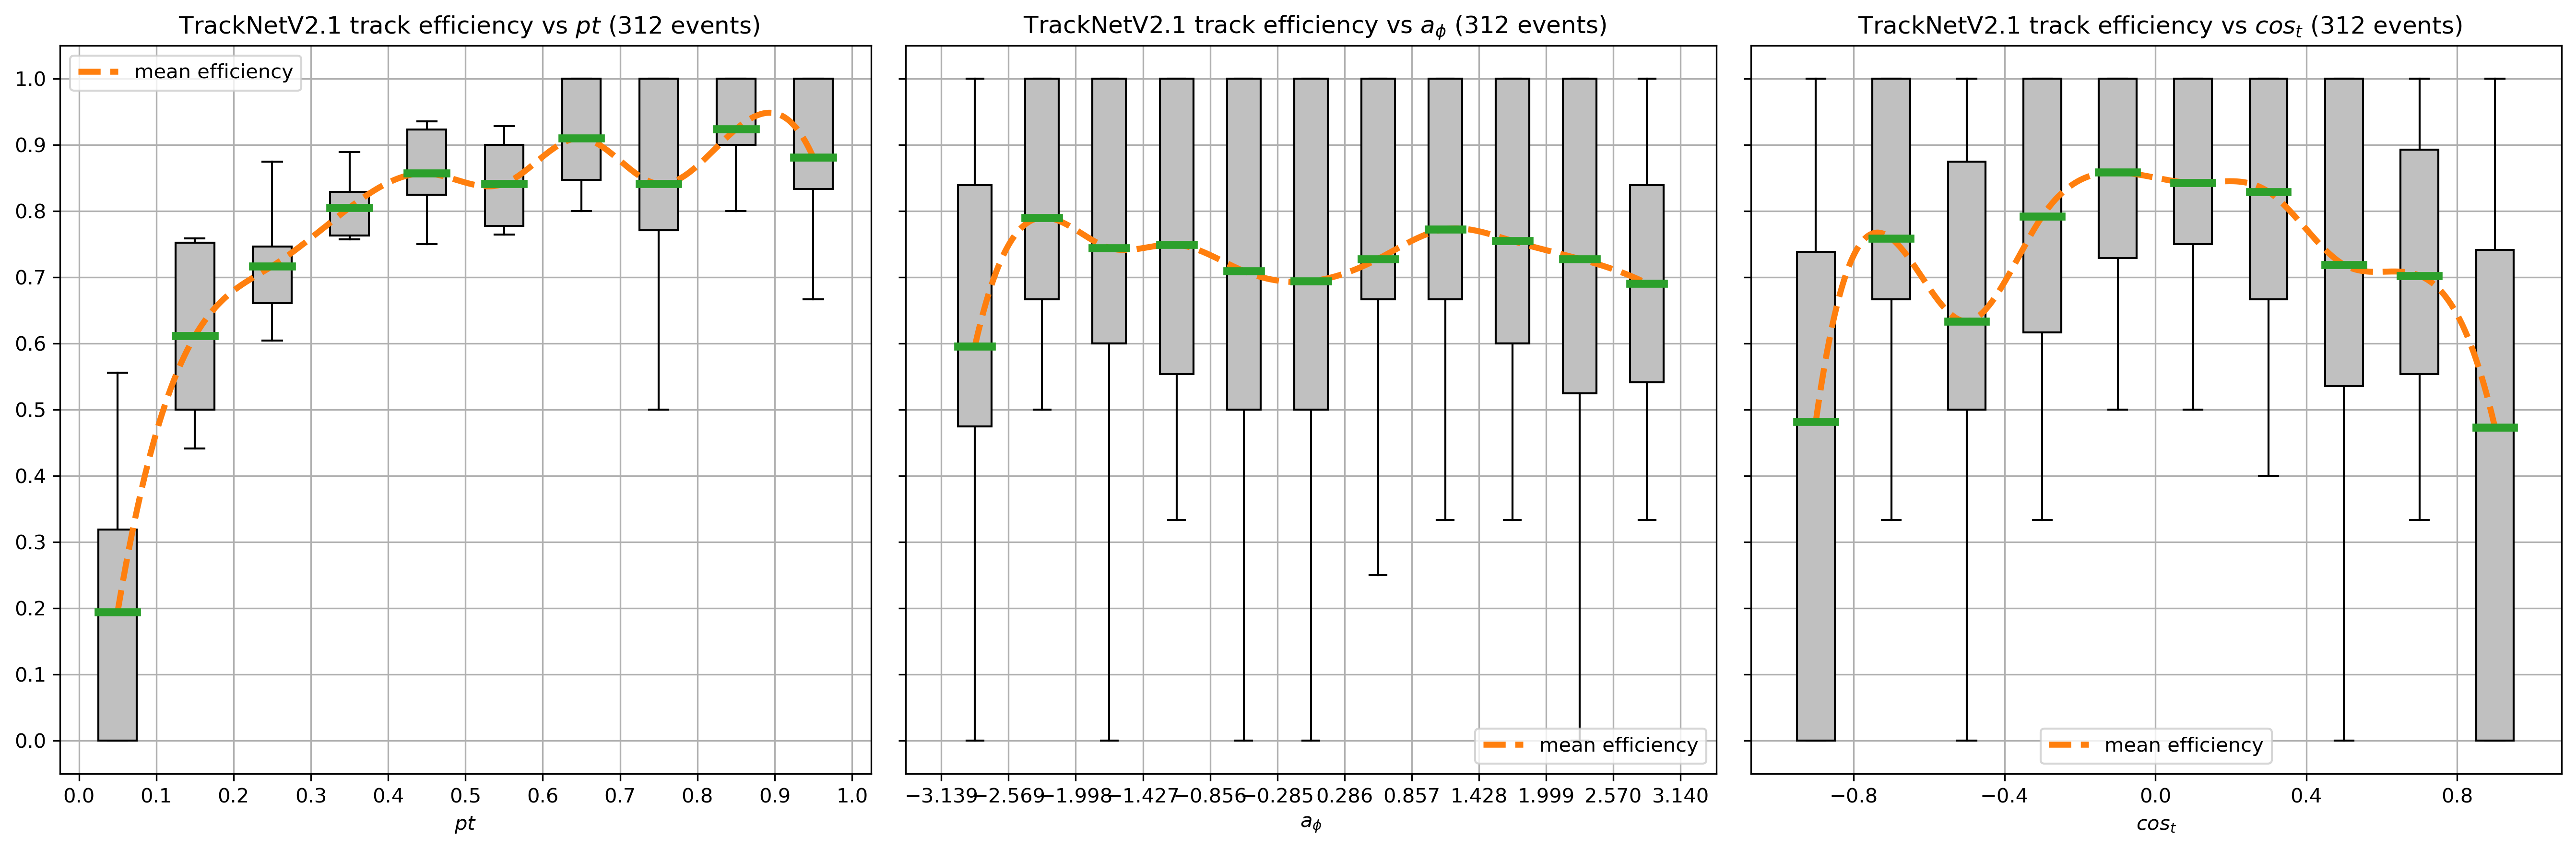

In [103]:
from numpy import linalg as LA
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

def draw_for_col(ax, tracks_real, tracks_pred_true,
                 col, col_pretty, total_events, n_ticks=150, 
                 n_avg_ticks=-1, x_ticks=8,
                 custom_title=None,
                 ticks_custom=True,
                 with_boxplot=False,
                 int_mode=False, save_disk=True,
                 custom_draw_funcs=[],
                 diagram_func=None,
                 color_ax_ticks=False,
                 model_name="NO_MODEL_NAME"
                ):
    real_xticks_count = x_ticks
    
    color_ax_ticks = len(custom_draw_funcs) > 0 and color_ax_ticks
    n_avg_ticks = n_ticks // 5 if n_avg_ticks < 0 else n_avg_ticks
    
    delta = 1e-4 if not int_mode else 1
    
    start = tracks_real[tracks_real[col] > -np.inf][col].min()
    end = tracks_real[tracks_real[col] < np.inf][col].max()+delta

    initial, spac = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, n_ticks, col)
    
    
    
    maxX = int(end) if int_mode else end
    #plt.figure(figsize=(8,7))
    
    #ax = plt.subplot(111)
    #ax.set_ylabel('Track efficiency', fontsize=12)
    #ax.set_xlabel(col_pretty, fontsize=12)
    ax.set_xlabel(col_pretty)
    ####plt.axis([0, maxX, 0, 1.005])
    ax.plot(spac, initial, alpha=0.0, lw=1)
    title = custom_title if custom_title else ' %s track efficiency vs %s (%d events)' % (model_name, col_pretty, total_events)
    #ax.set_title(title, fontsize=14)
    
    ax.set_title(title)
    
    if not int_mode and ticks_custom:
        ax.set_xticks(np.linspace(start, maxX, x_ticks))
    else:
        ax.locator_params(axis='x', nbins=x_ticks)

    if diagram_func is None:
        ax.set_yticks(np.round(np.linspace(0, 1, 11), decimals=2))
    x_ticks = ax.get_xticks()
    
    if with_boxplot:
        old_ticks = x_ticks
        delta_x = (x_ticks[1] - x_ticks[0])/2
        diagram_func = get_diagram_for_boxplot if diagram_func is None else diagram_func
        
        box_data, ticks_x, mean_data = diagram_func(tracks_real, tracks_pred_true, start, end, 
                                                               n_ticks, col, x_ticks, int_mode)
        bp = ax.boxplot(box_data, positions=ticks_x, 
                    manage_ticks=False, meanline=True, showmeans=True,
                    widths=delta_x,patch_artist=True, sym='',zorder=3)
        boxplot_style(bp)

        # mean line
        xnew = np.linspace(ticks_x.min(), ticks_x.max(), 500) 

        spl = make_interp_spline(ticks_x, mean_data, k=3)  # type: BSpline
        power_smooth = spl(xnew)
        ax.plot(xnew, power_smooth, ls='--', color='tab:orange', label='mean efficiency', lw=3, zorder=4)
        ax.set_xticks(old_ticks)
    
    if int_mode or not ticks_custom:
        ax.locator_params(axis='x', nbins=real_xticks_count)
    
    if diagram_func is None:
        ax.set_ylim((-0.05, 1.05))
    for draw_f in custom_draw_funcs:
        draw_f(ax)
    ####plt.locator_params(axis='y', nbins=16)
    ax.legend(loc=0) 
    if color_ax_ticks:
        ax.tick_params(axis='y', labelcolor='tab:green')
    ax.grid()

    #plt.tight_layout()
    #plt.rcParams['savefig.facecolor']='white'
    #os.makedirs('../output', exist_ok=True)
    #plt.savefig('../output/new_img_track_eff_%s_ev%r_t%d.png'%(col, total_events, n_ticks), dpi=300)
    #plt.show()


def plot_model_results(model_name, model_results):
    all_tracks_df = model_results[0]
    
    all_tracks_df['pt'] = LA.norm(all_tracks_df[['px','py']].values, axis=1)
    all_tracks_df['cos_t'] = (all_tracks_df[['pz']].values/ LA.norm(all_tracks_df[['px','py','pz']].values, axis=1, keepdims=True))
    all_tracks_df['a_phi'] = np.arctan2(all_tracks_df[['px']].values, all_tracks_df[['py']].values)
    
    tracks_real = all_tracks_df[all_tracks_df.pred != -1]
    tracks_pred_true = all_tracks_df[all_tracks_df.pred == 1]

    
    fig = plt.figure(figsize=(18,6), dpi=300)
    ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey='all')
    draw_for_col(ax1, tracks_real, tracks_pred_true, 'pt', '$pt$', n_events, 80, 
             n_avg_ticks=48, x_ticks=16, ticks_custom=False, with_boxplot=True, model_name=model_name)
    #plt.ylabel('Track efficiency', fontsize=12)
    
    draw_for_col(ax2, tracks_real, tracks_pred_true, 'a_phi', '$a_\phi$',n_events, 350, 
                 n_avg_ticks=60, x_ticks=12, with_boxplot=True, model_name=model_name)
    
    draw_for_col(ax3, tracks_real, tracks_pred_true,'cos_t', '$cos_t$',n_events, 350, n_avg_ticks=60,x_ticks=12, ticks_custom=False, with_boxplot=True, model_name=model_name)
    plt.tight_layout()
    plt.rcParams['savefig.facecolor']='white'
    plt.show()
    pass

plot_model_results("TrackNetV2.1", res)